In [1]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-xde/notebooks'

In [2]:
%load_ext autoreload
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../deepxde/')
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde
deepxde

Using backend: pytorch



<module 'deepxde' from '/ocean/projects/asc170022p/mtragoza/mre-xde/notebooks/../../deepxde/deepxde/__init__.py'>

# 2D inverse Helmholtz problem

We would like to solve an inverse problem for a *two-dimensional* Helmholtz equation:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    G \left(\frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} \right) &= -\rho \omega^2 u
\end{align}
$$

Where the goal is to recover $G(x)$ given a training data set of $((x, u(x))$ pairs.

## Define the geometry

We will use DeepXDE to solve the PDE on the square domain $x \in [-1, 1]^2$.


In [3]:
# define the geometry (i.e. domain of x)
geom = deepxde.geometry.Rectangle([-1, -1], [1, 1])
print(geom)
print(f'dim = {geom.dim}\nbbox = {geom.bbox}\nperimeter = {geom.perimeter}\narea = {geom.area}')

dim = 2
bbox = (array([-1., -1.], dtype=float32), array([1., 1.], dtype=float32))
perimeter = 8.0
area = 4.0


## Define the PDE residual

Given some candidate solution $(\hat{u}, \hat{q})$, we can rearrange the PDE to obtain a residual:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    0 &= G \nabla^2 u + \rho \omega^2 u \\
    r(x, \hat{u}, \hat{G}) &= \hat{G} \nabla^2 \hat{u} + \rho \omega^2 \hat{u}
\end{align}
$$

We will train a neural network to minimize this residual, subject to constraints in the form of a set of training data points.

In [4]:
# define the residual of the PDE

rho = 1
omega = 2*np.pi * 2

def pde(x, u_G):
    '''
    Compute PDE residual.
    '''
    u, G = u_G[:,0:1], u_G[:,1:2]
    u_xx = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=0, j=0 # indices into dim_x
    )
    u_yy = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=1, j=1 # indices into dim_x
    )
    return G * (u_xx + u_yy) + rho * omega**2 * u

## Define a reference solution

Given some true stiffness function $G(x)$ and boundary conditions, we can solve for the displacement (i.e. the forward problem) using finite differences:

$$
\begin{align}
    G \left(\frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} \right) &= -\rho \omega^2 u \\
    G_{i,j} \left( \frac{u_{i+1,j} - 2 u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2 u_{i,j} + u_{i,j-1}}{h^2} \right) &= -\rho \omega^2 u_{i,j} \\
    G_{i,j} \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) &= -\rho \omega^2 u_{i,j} \\
    G_{i,j} \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) + \rho \omega^2 u_{i,j} &= 0 \\
    \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) + \rho \omega^2 \frac{u_{i,j}}{G_{i,j}} &= 0 \\
    \mathbf{L} \mathbf{u} + \rho \omega^2 \mathbf{G} \mathbf{u} &= 0 \\
    \left( \mathbf{L} + \rho \omega^2 \mathbf{G} \right) \mathbf{u} &= 0 \\
    \mathbf{A} \mathbf{u} &= 0
\end{align}
$$

We will use this approach to define a reference solution to the PDE for training the model.

In [5]:
# functions for defining a 2d discrete Laplacian matrix

def tridiag(a, b, c, n):
    return (
        a * (np.tri(n, k=-1) - np.tri(n, k=-2)) +
        b * np.eye(n) +
        c * (np.tri(n, k=1) - np.tri(n, k=0))
    )

def laplacian_matrix_2d(n_x, dx):
    mats = []
    for i in range(n_x):
        mats.append([])
        for j in range(n_x):
            diag = abs(i - j)
            if diag == 0:
                m = tridiag(1, -4, 1, n_x)
            elif diag == 1:
                m = tridiag(0, 1, 0, n_x)
            else:
                m = np.zeros((n_x, n_x))
            mats[-1].append(m)
    return np.block(mats) / dx**2

def print_mat(**kwargs):
    for k, v in kwargs.items():
        v_str = str(v).replace('\n', '\n    ')
        print(f'{k} = \n    {v_str}')

L = laplacian_matrix_2d(n_x=3, dx=1)
print_mat(L=L)

L = 
    [[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
     [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
     [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
     [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
     [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
     [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
     [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
     [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
     [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


In [6]:
# implicit method using block tridiagonal linear system

def implicit_solver_2d(x, n_x, dx, G, u0, rho, omega):

    # set up linear system
    L = laplacian_matrix_2d(n_x, dx)
    G = np.diag(1 / G[:,0])

    A = L + rho * omega**2 * G
    b = np.zeros(n_x**2)
    
    # determine boundary nodes
    on_boundary = (np.abs(x).max(axis=1) == 1.0)
    
    # set boundary conditions
    A[on_boundary,:] = 0
    A[on_boundary,on_boundary] = 1
    b[on_boundary] = u0[on_boundary,0]
    
    # solve linear system
    u = np.linalg.solve(A, b)

    return u.reshape(-1, 1)

# define the reference solution

def solution(x, n_x, dx):
    '''
    Compute reference solution.
    '''    
    # true stiffness function
    G = np.ones((n_x**2, 1)) * rho
    G = G + np.exp(-((x - [-0.5, 0.5])**2).sum(axis=1, keepdims=True)*100) * rho*3
    G = G + np.exp(-((x - [0.5, 0.5])**2).sum(axis=1, keepdims=True)*100) * -rho/2
    G = G + np.exp(-((x - [-0.5, -0.5])**2).sum(axis=1, keepdims=True)*100) * -rho/2
    G = G + np.exp(-((x - [0.5, -0.5])**2).sum(axis=1, keepdims=True)*100) * rho

    # solve for displacement field
    u = np.cos(omega * x[:,1:2])
    u = implicit_solver_2d(x, n_x, dx, G, u, rho, omega)  

    return u, G

## Define the training data points

We can then use the reference solution to create a set of training data points.

In [8]:
# define the training data set

def gen_train_data(n_x):
    '''
    Generate training data for PDE.
    '''
    x = np.linspace(-1, 1, n_x)
    dx = x[1] - x[0]
    x = np.dstack(np.meshgrid(x, x)).reshape(-1, 2)
    u, G = solution(x, n_x, dx)
    return x, u, G

n_train = 100 # training points along each dimension

x, u_true, G_true = gen_train_data(n_train)

print(x.shape, u_true.shape, G_true.shape)

(10000, 2) (10000, 1) (10000, 1)


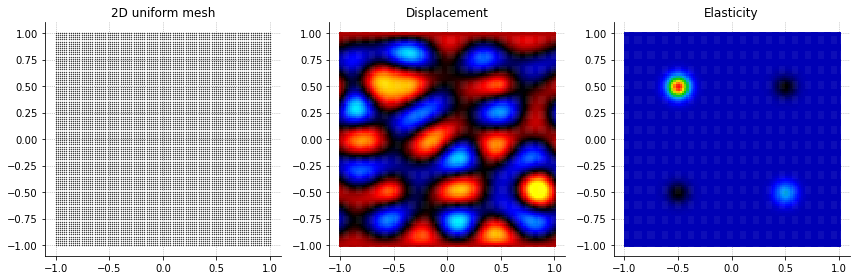

In [14]:
import matplotlib as mpl

def phase_color_map():
    '''
    Create a colormap for MRE wave images
    from yellow, red, black, blue, to cyan.
    '''
    cyan   = (0, 1, 1)
    blue   = (0, 0, 1)
    black  = (0, 0, 0)
    red    = (1, 0, 0)
    yellow = (1, 1, 0)

    colors = [cyan, blue, black, red, yellow]

    return mpl.colors.LinearSegmentedColormap.from_list(
        name='wave', colors=colors, N=255
    )

def elast_color_map():
    '''
    Create a colormap for MRE elastrograms
    from dark, blue, cyan, green, yellow, to red.
    '''
    p = 0.0
    c = 0.6
    y = 0.9
    g = 0.8

    dark = (p, 0, p)
    blue   = (0, 0, 1)
    cyan   = (0, c, 1)
    green  = (0, g, 0)
    yellow = (1, y, 0)
    red    = (1, 0, 0)

    colors = [dark, blue, cyan, green, yellow, red]

    return mpl.colors.LinearSegmentedColormap.from_list(
        name='wave', colors=colors, N=255
    )

phase_cmap = phase_color_map()
elast_cmap = elast_color_map()

def plot_2d(x, u, G):
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    size = 25000 / n_train**2
    
    # plot mesh
    ax = axes[0]
    ax.set_title('2D uniform mesh')
    ax.scatter(x[:,0], x[:,1], color='black', s=size/20)
    
    # plot displacement
    ax = axes[1]
    ax.set_title('Displacement')
    ax.scatter(x[:,0], x[:,1], c=u[:,0], cmap=phase_cmap, marker='s', s=size, vmin=-3, vmax=3)
    
    # plot stiffness
    ax = axes[2]
    ax.set_title('Elasticity')
    ax.scatter(x[:,0], x[:,1], c=G[:,0], cmap=elast_cmap, marker='s', s=size)
               
    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')

    sns.despine(fig)
    fig.tight_layout()

plot_2d(x, u_true, G_true)

In [9]:
%autoreload

# data is defined by a geometry, PDE residual, and boundary conditions

n_domain =  200 # random samples in domain for PDE loss
n_test   = 1000 # test evaluation points

point_set = deepxde.icbc.PointSetBC(
    points=x, # array of points where target values are known
    values=u_true, # array of values of the exact solution
    component=0
)

data = deepxde.data.PDE(
    geometry=geom, # an instance of Geometry
    pde=pde, # a global PDE or a list of PDEs
    bcs=[point_set], # a boundary condition or list of boundary conditions
    num_domain=n_domain,
    anchors=x, # array of training points in addition to num_domain and num_boundary points
    num_test=n_test # number of points sampled inside the boundary the domain for testing
)

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-XDE/lib/python3.10/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "


In [10]:
n_layers = 5
n_hidden = 128
activ_fn = 'sin'

net = deepxde.nn.PFNN(
    layer_sizes=[2] + [[n_hidden, n_hidden]] * (n_layers-1) + [2],
    activation=activ_fn,
    kernel_initializer="Glorot uniform"
)
net

PFNN(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=128, out_features=1, bias=True)
      (1): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [11]:
model = deepxde.Model(data, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-5, 1]
)

Compiling model...
'compile' took 0.000496 s



In [17]:
loss_history, train_state = model.train(epochs=10000)

Training model...

Step      Train loss              Test loss               Test metric
10000     [1.51e-04, 2.50e-04]    [1.55e-04, 2.50e-04]    []  
11000     [6.72e-04, 1.07e-03]    [7.09e-04, 1.07e-03]    []  
12000     [6.65e-05, 8.12e-05]    [6.73e-05, 8.12e-05]    []  
13000     [5.98e-05, 6.55e-05]    [6.08e-05, 6.55e-05]    []  
14000     [1.18e-04, 1.76e-04]    [1.23e-04, 1.76e-04]    []  
15000     [3.94e-05, 4.11e-05]    [3.94e-05, 4.11e-05]    []  
16000     [6.91e-05, 1.57e-04]    [6.96e-05, 1.57e-04]    []  
17000     [6.23e-05, 1.40e-04]    [6.20e-05, 1.40e-04]    []  
18000     [7.85e-05, 1.67e-04]    [7.95e-05, 1.67e-04]    []  
19000     [6.15e-05, 2.49e-04]    [6.21e-05, 2.49e-04]    []  
20000     [2.14e-04, 1.02e-03]    [2.20e-04, 1.02e-03]    []  

Best model at step 15000:
  train loss: 8.05e-05
  test loss: 8.05e-05
  test metric: []

'train' took 304.757328 s



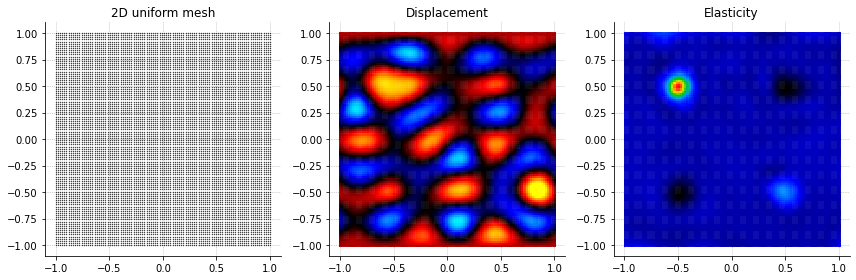

In [18]:
# view results
x, u_true, G_true = gen_train_data(n_train)

u_G_pred = model.predict(x)
u_pred, G_pred = u_G_pred[:, 0:1], u_G_pred[:, 1:2]

plot_2d(x, u_pred, G_pred)

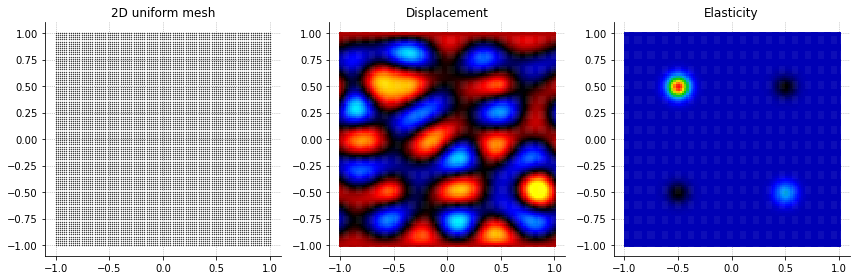

In [19]:
plot_2d(x, u_true, G_true)